## Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
#https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

In [2]:
prepared_df = pd.read_csv(r"data/prepared_data.csv")
prepared_df['datetime'] = pd.to_datetime(prepared_df['datetime'])
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113687 entries, 0 to 113686
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   datetime       113687 non-null  datetime64[ns]
 1   campaign_id    113687 non-null  object        
 2   time           113687 non-null  object        
 3   spend          113687 non-null  float64       
 4   impressions    113687 non-null  float64       
 5   clicks         113687 non-null  float64       
 6   purchase       113687 non-null  float64       
 7   hour           113687 non-null  float64       
 8   unique_ids     113687 non-null  object        
 9   first_24_hour  113687 non-null  bool          
 10  test_set       113687 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(5), object(3)
memory usage: 8.0+ MB


## Defining and calculate Target Metric 
    The target metric consists of two KPI
    - Click Through Rate: clicks/impressions
    - Conversion Rate: purchase/clicks
   **A custom weighted conversion rate:** $(avgCTR+2*avgConversionRate)/3$
   
   <span style="font-family:Comic Sans MS">
    <a href="https://www.wordstream.com/click-through-rate">Average CTR: 0.35%</a>
    <br>
    <a href="https://www.wordstream.com/blog/ws/2014/03/17/what-is-a-good-conversion-rate#:~:text=going%20to%20go%3F-,But%20what%20is%20a%20good%20conversion%20rate%3F,rates%20of%2011.45%25%20or%20higher.">Average Conversion rate: 2.35%</a>
   </span>

Ads beyond the threshold of the custom weighted conversion rate: 1.683 will be considered as good ads.

In [3]:
avg_custom_conversion_rate = 1.683

#calculate ctr and checks for non-sensical value (i.e. >100%)
prepared_df['ctr'] = prepared_df.clicks/prepared_df.impressions*100
prepared_df.loc[prepared_df['ctr'] ==np.inf, 'ctr'] = 100
prepared_df.loc[prepared_df['ctr']>100, 'ctr'] = 100
prepared_df['ctr'] = prepared_df['ctr'].fillna(0)

#calculate conversion rate  and checks for non-sensical value (i.e. >100%)
prepared_df['conversion_rate'] = prepared_df.purchase/prepared_df.clicks*100
prepared_df.loc[prepared_df['conversion_rate'] ==np.inf, 'conversion_rate'] = 100
prepared_df.loc[prepared_df['conversion_rate']>100, 'conversion_rate'] = 100
prepared_df['conversion_rate'] = prepared_df['conversion_rate'].fillna(0)

#calculate custom conversion rate
prepared_df['custom_conversion_rate'] = (prepared_df['ctr']+(prepared_df['conversion_rate']*2))/3
prepared_df['good_performance'] = prepared_df['custom_conversion_rate']>=avg_custom_conversion_rate

#extract hour
prepared_df['hour'] = prepared_df['datetime'].dt.hour
prepared_df['dayofweek'] = prepared_df['datetime'].dt.dayofweek

#extract boolean clicked and purchase value
prepared_df['clicked'] = prepared_df['clicks']>0
prepared_df['purchased'] = prepared_df['purchase']>0

#Creates next hour customer conversion rate column
prepared_df = prepared_df.assign(next_hour_custom_conversion_rate = prepared_df.groupby(['unique_ids']).custom_conversion_rate.shift(-1))
prepared_df = prepared_df.assign(next_hour_good_performance = prepared_df.groupby(['unique_ids']).good_performance.shift(-1))

# # extracts next hour clicks and purchase
prepared_df = prepared_df.assign(next_hour_clicks = prepared_df.groupby(['unique_ids']).clicks.shift(-1))
prepared_df = prepared_df.assign(next_hour_purchases = prepared_df.groupby(['unique_ids']).purchase.shift(-1))

print(prepared_df.shape[0],
      len(prepared_df['unique_ids'].unique()),  
      prepared_df.shape[0]/len(prepared_df['unique_ids'].unique()))

#campaign_id_23843427462090549_ad_id_23843429354180549
#prepared_df = prepared_df[prepared_df['prediction_horizon'] | prepared_df['first_24_hour']]

#prepared_df  = prepared_df.dropna()
##prepared_df

113687 870 130.67471264367816


## EDA

In [25]:
full_data = prepared_df[prepared_df['test_set'] | prepared_df['first_24_hour']]

full_data ['campaign_id'] = full_data['unique_ids'].apply(lambda x: str(x).split('_')[2])
unique_campaigns = list(full_data['campaign_id'].unique())
full_data ['campaign_id'] = full_data['campaign_id'].apply(lambda x: unique_campaigns.index(x))

print('Total data size: ', full_data.shape[0])


Total data size:  23488


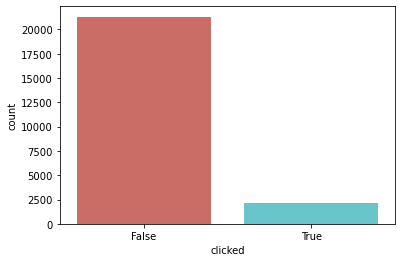

In [5]:
sns.countplot(x='clicked',data=full_data, palette='hls')
plt.show();

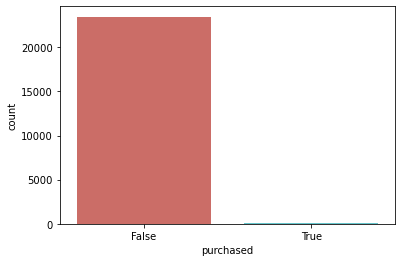

In [198]:
sns.countplot(x='purchased',data=full_data, palette='hls')
plt.show();

### Ad Classification!

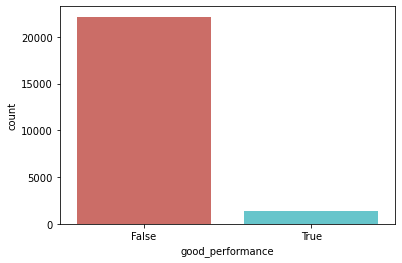

In [199]:
sns.countplot(x='good_performance',data=full_data, palette='hls')
plt.show();

#### Next day ad performance

Training data %:  88.89645776566758
Training data ads performing good:  1179
5.646551724137931%


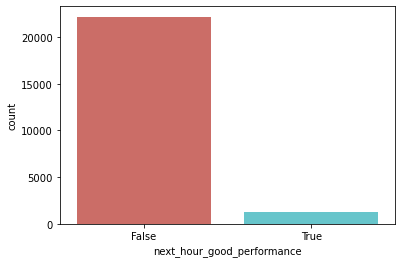

In [200]:
training_data = full_data[full_data['first_24_hour']]
print('Training data %: ', (100*training_data.shape[0])/full_data.shape[0])

good_ads = training_data[(training_data.next_hour_good_performance>0) &\
                  (training_data.first_24_hour>0)].shape[0]


print('Training data ads performing good: ', good_ads)
print('{}%'.format((100*good_ads)/training_data.shape[0]))

sns.countplot(x='next_hour_good_performance', data=full_data, palette='hls')
plt.show()

### Class Balance In test set

Test data total ads:  2608
Number of ads with good performance: 135
5.17638036809816%


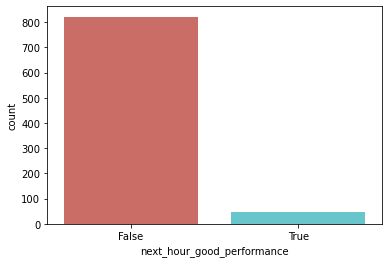

In [201]:
#Class Balance In test set: 
#41 vs 829 with actual threshold~6%

test_set = full_data[full_data['test_set']]
print('Test data total ads: ', test_set.shape[0])
print('Number of ads with good performance: {}'.format(test_set[test_set.next_hour_good_performance>0].shape[0]))
print('{}%'.format((100*test_set[test_set.next_hour_good_performance>0].shape[0])/test_set.shape[0]))
sns.countplot(x='next_hour_good_performance',data=get_last_hour_labels, palette='hls')
plt.show()

### Hourly Pattern

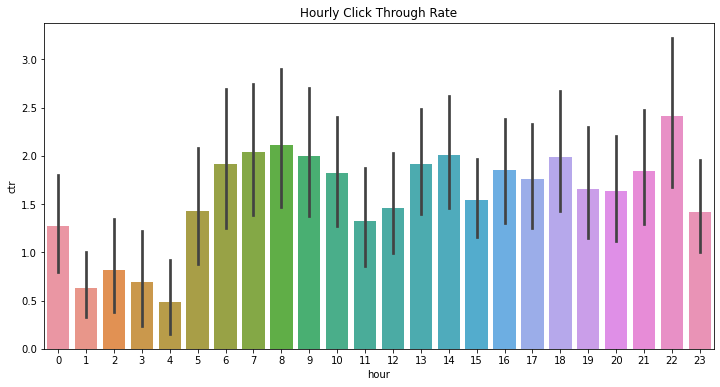

In [202]:
plt.figure(figsize=(12,6))
sns.barplot(y='ctr', x='hour', data=full_data)
plt.title('Hourly Click Through Rate');

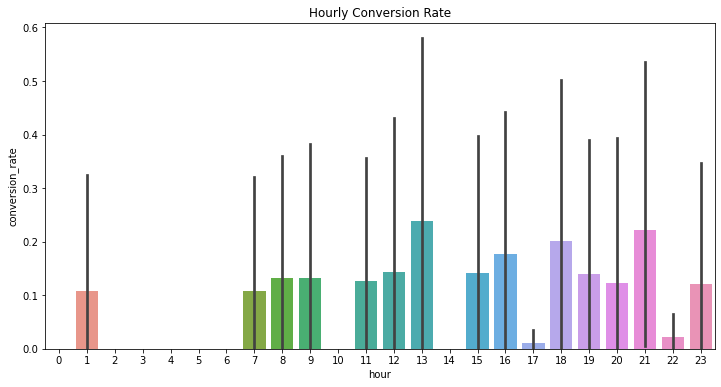

In [203]:
plt.figure(figsize=(12,6))
sns.barplot(y='conversion_rate', x='hour', data=full_data)
plt.title('Hourly Conversion Rate');

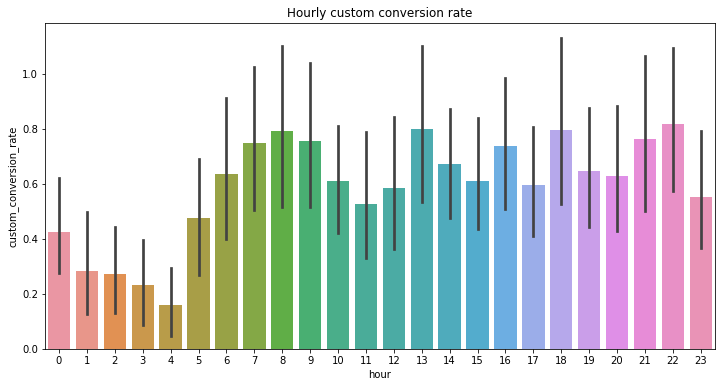

In [204]:
plt.figure(figsize=(12,6))
sns.barplot(y='custom_conversion_rate', x='hour', data=full_data)
plt.title('Hourly custom conversion rate');

### Day Of Week

In [6]:
# plt.figure(figsize=(12,6))
# sns.barplot(y='ctr', x='dayofweek', data=full_data)
# plt.title('Day of week Click Through Rate');

In [7]:
# plt.figure(figsize=(12,6))
# sns.barplot(y='conversion_rate', x='dayofweek', data=full_data)
# plt.title('Day of week Conversion Rate');

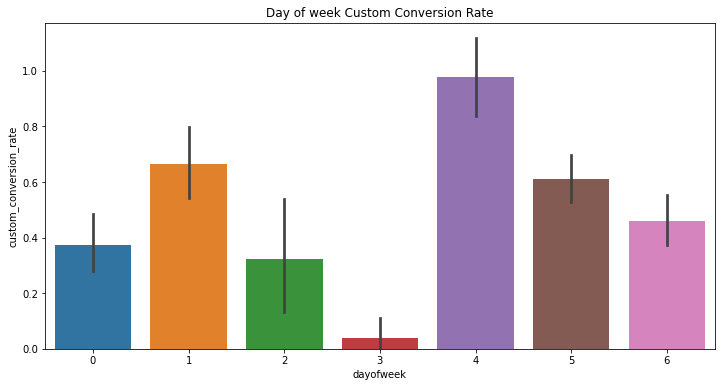

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(y='custom_conversion_rate', x='dayofweek', data=full_data)
plt.title('Day of week Custom Conversion Rate');

#### Impact of campaign

F:\miniconda3\envs\lfi\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='campaign_id', ylabel='Density'>

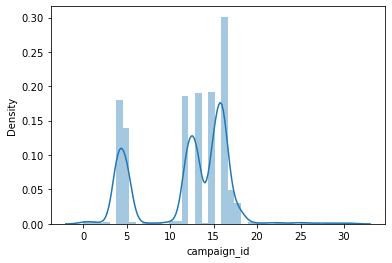

In [36]:
#Campaign Id Histogram
sns.distplot(full_data['campaign_id'])

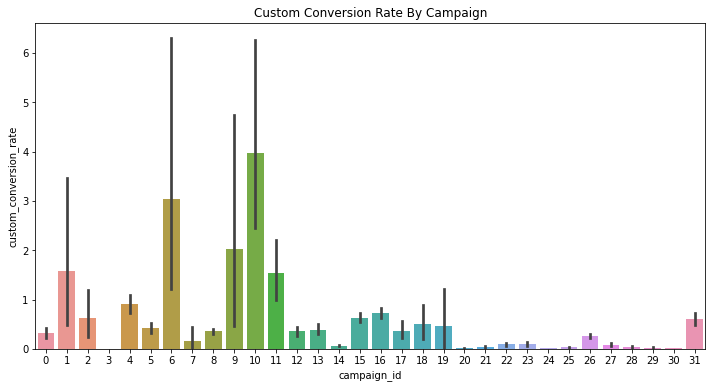

In [31]:
plt.figure(figsize=(12,6))
ax = sns.barplot(y='custom_conversion_rate', x='campaign_id', data=full_data)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Custom Conversion Rate By Campaign');

<AxesSubplot:xlabel='spend', ylabel='custom_conversion_rate'>

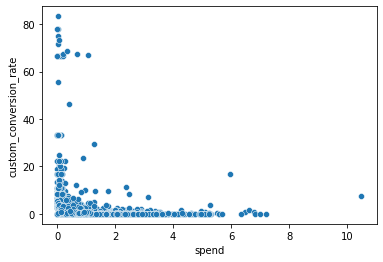

In [44]:
sns.scatterplot(data=full_data, x="spend", y="custom_conversion_rate")

In [223]:
missed_purchase_infos = df[(~df.unique_ids.isin(prepared_df.unique_ids.unique())) &(df.purchase>0)]
missed_purchase_infos.unique_ids.values

array(['campaign_id_23845255826960549_ad_id_23845265141010549',
       'campaign_id_23845255826960549_ad_id_23845265141010549',
       'campaign_id_23845255826960549_ad_id_23845256153090549',
       'campaign_id_23845255826960549_ad_id_23845256153090549',
       'campaign_id_23845255826960549_ad_id_23845256153090549',
       'campaign_id_23845255826960549_ad_id_23845256153090549'],
      dtype=object)

## Relationships

In [45]:
sample_features = ['hour', 'dayofweek','spend', 'impressions', 'ctr', 'conversion_rate', 'custom_conversion_rate', 'next_hour_custom_conversion_rate']
full_data[sample_features].corr(method ='pearson')

,hour,dayofweek,spend,impressions,ctr,conversion_rate,custom_conversion_rate,next_hour_custom_conversion_rate
hour,1.000000,0.087060,0.070280,0.012286,0.030730,0.013511,0.032729,0.023634
dayofweek,0.087060,1.000000,-0.011246,-0.031718,0.016011,-0.012777,0.006690,0.004326
spend,0.070280,-0.011246,1.000000,0.579817,0.010817,0.027620,0.023476,0.012918
impressions,0.012286,-0.031718,0.579817,1.000000,-0.009483,0.006061,-0.004750,-0.006123
ctr,0.030730,0.016011,0.010817,-0.009483,1.000000,0.033328,0.852561,0.038363
conversion_rate,0.013511,-0.012777,0.027620,0.006061,0.033328,1.000000,0.550752,0.008805
custom_conversion_rate,0.032729,0.006690,0.023476,-0.004750,0.852561,0.550752,1.000000,0.036642
next_hour_custom_conversion_rate,0.023634,0.004326,0.012918,-0.006123,0.038363,0.008805,0.036642,1.000000
